in order to build a neural netqork we need several things:
- correctly proccessed data
- an architecture (a working one...)
- an optimizer (that will try to improve the weights in our NN during the training)
- a loss function (that will compute the changes after each round of the training)

**Data**

any data should be converted into vector representations*. Vector representations for texts are called embeddings. Embeddings could be obtained using various ways:
- a special layer inside our neural network that will convert each word (or character (or even sentence which is not recommended)) into a vector and then improve this representation during the training
- a language model taken from somewhere which will convert our texts before the training (we may take fasttext, word2vec, bert, skipthoughts etc.)
- some statistic methods like TF-IDF

*other types of data, for example, images can also be converted into the matrices using an RGB of the colors with which each pixel of the image is created

**Architecture**

pytorch suggests us a lot of layers that could be stacked together in order to produce new models. The most useful for NLP purposes are:
- recurrent layers (RNN, GRU, LSTM)
- convolution and maxpooling layers
- linear layer for producing the distribution of probabilities over our classes

We may also use pretrained models for fine-tuning them inside our model or using a part of their architecture 

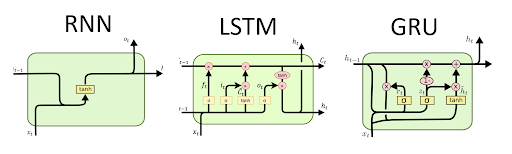

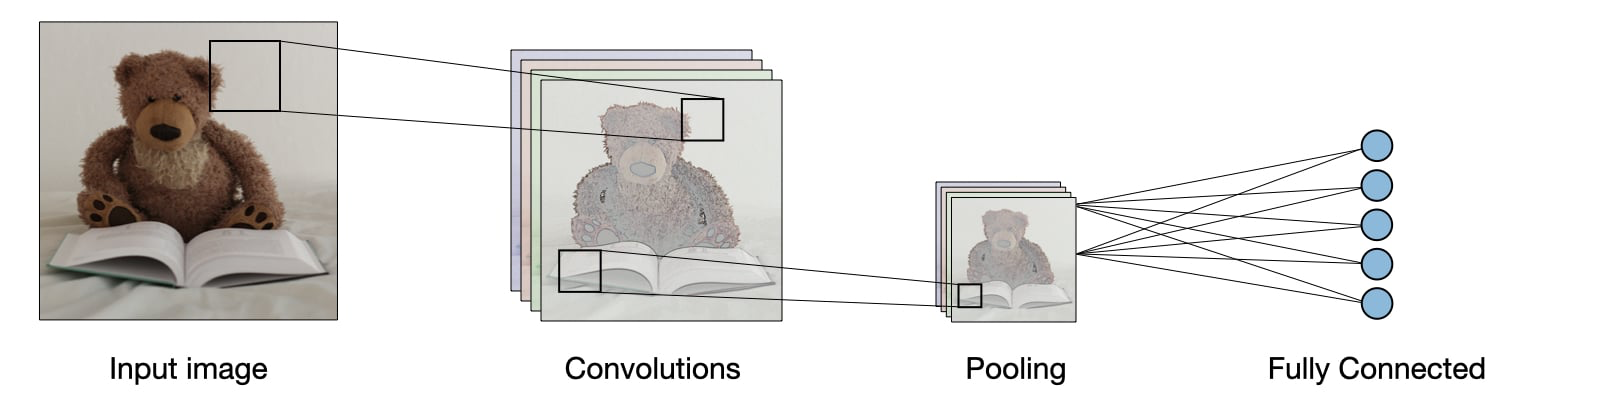

**Loss**

Loss function computes an error between the actual predictions and the desired ones. The output of this function is used for optimizing the weights using the optimization function. Loss functions usually differ from one task to another

**Optimizer**


Using the output of the loss function optimizers compute the changes that should be done for each of the layers of the neural network in order to get closer to the desired function

There are a lot of optimizers in pytorch among which these are the most useful:
- SGD
- Adam
- Adadelta
- Adagrad
- RMSProp

the pipeline

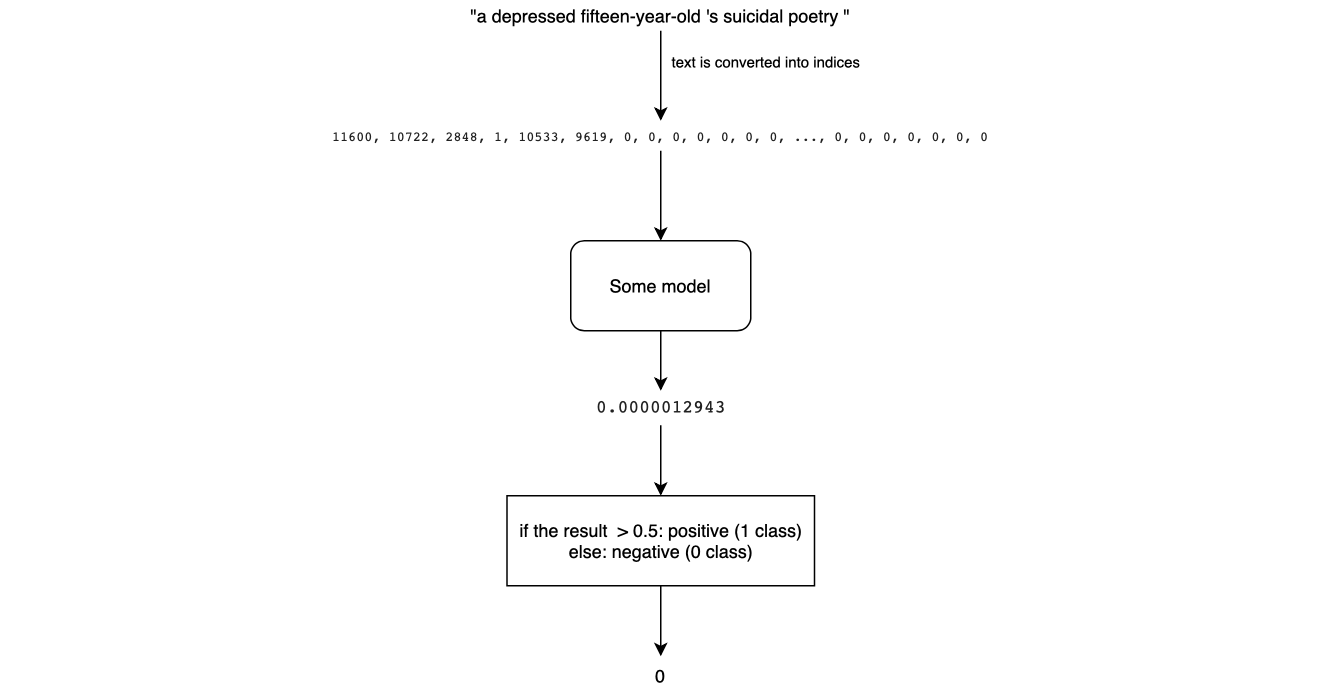

An example of a model (we will implement this model below)

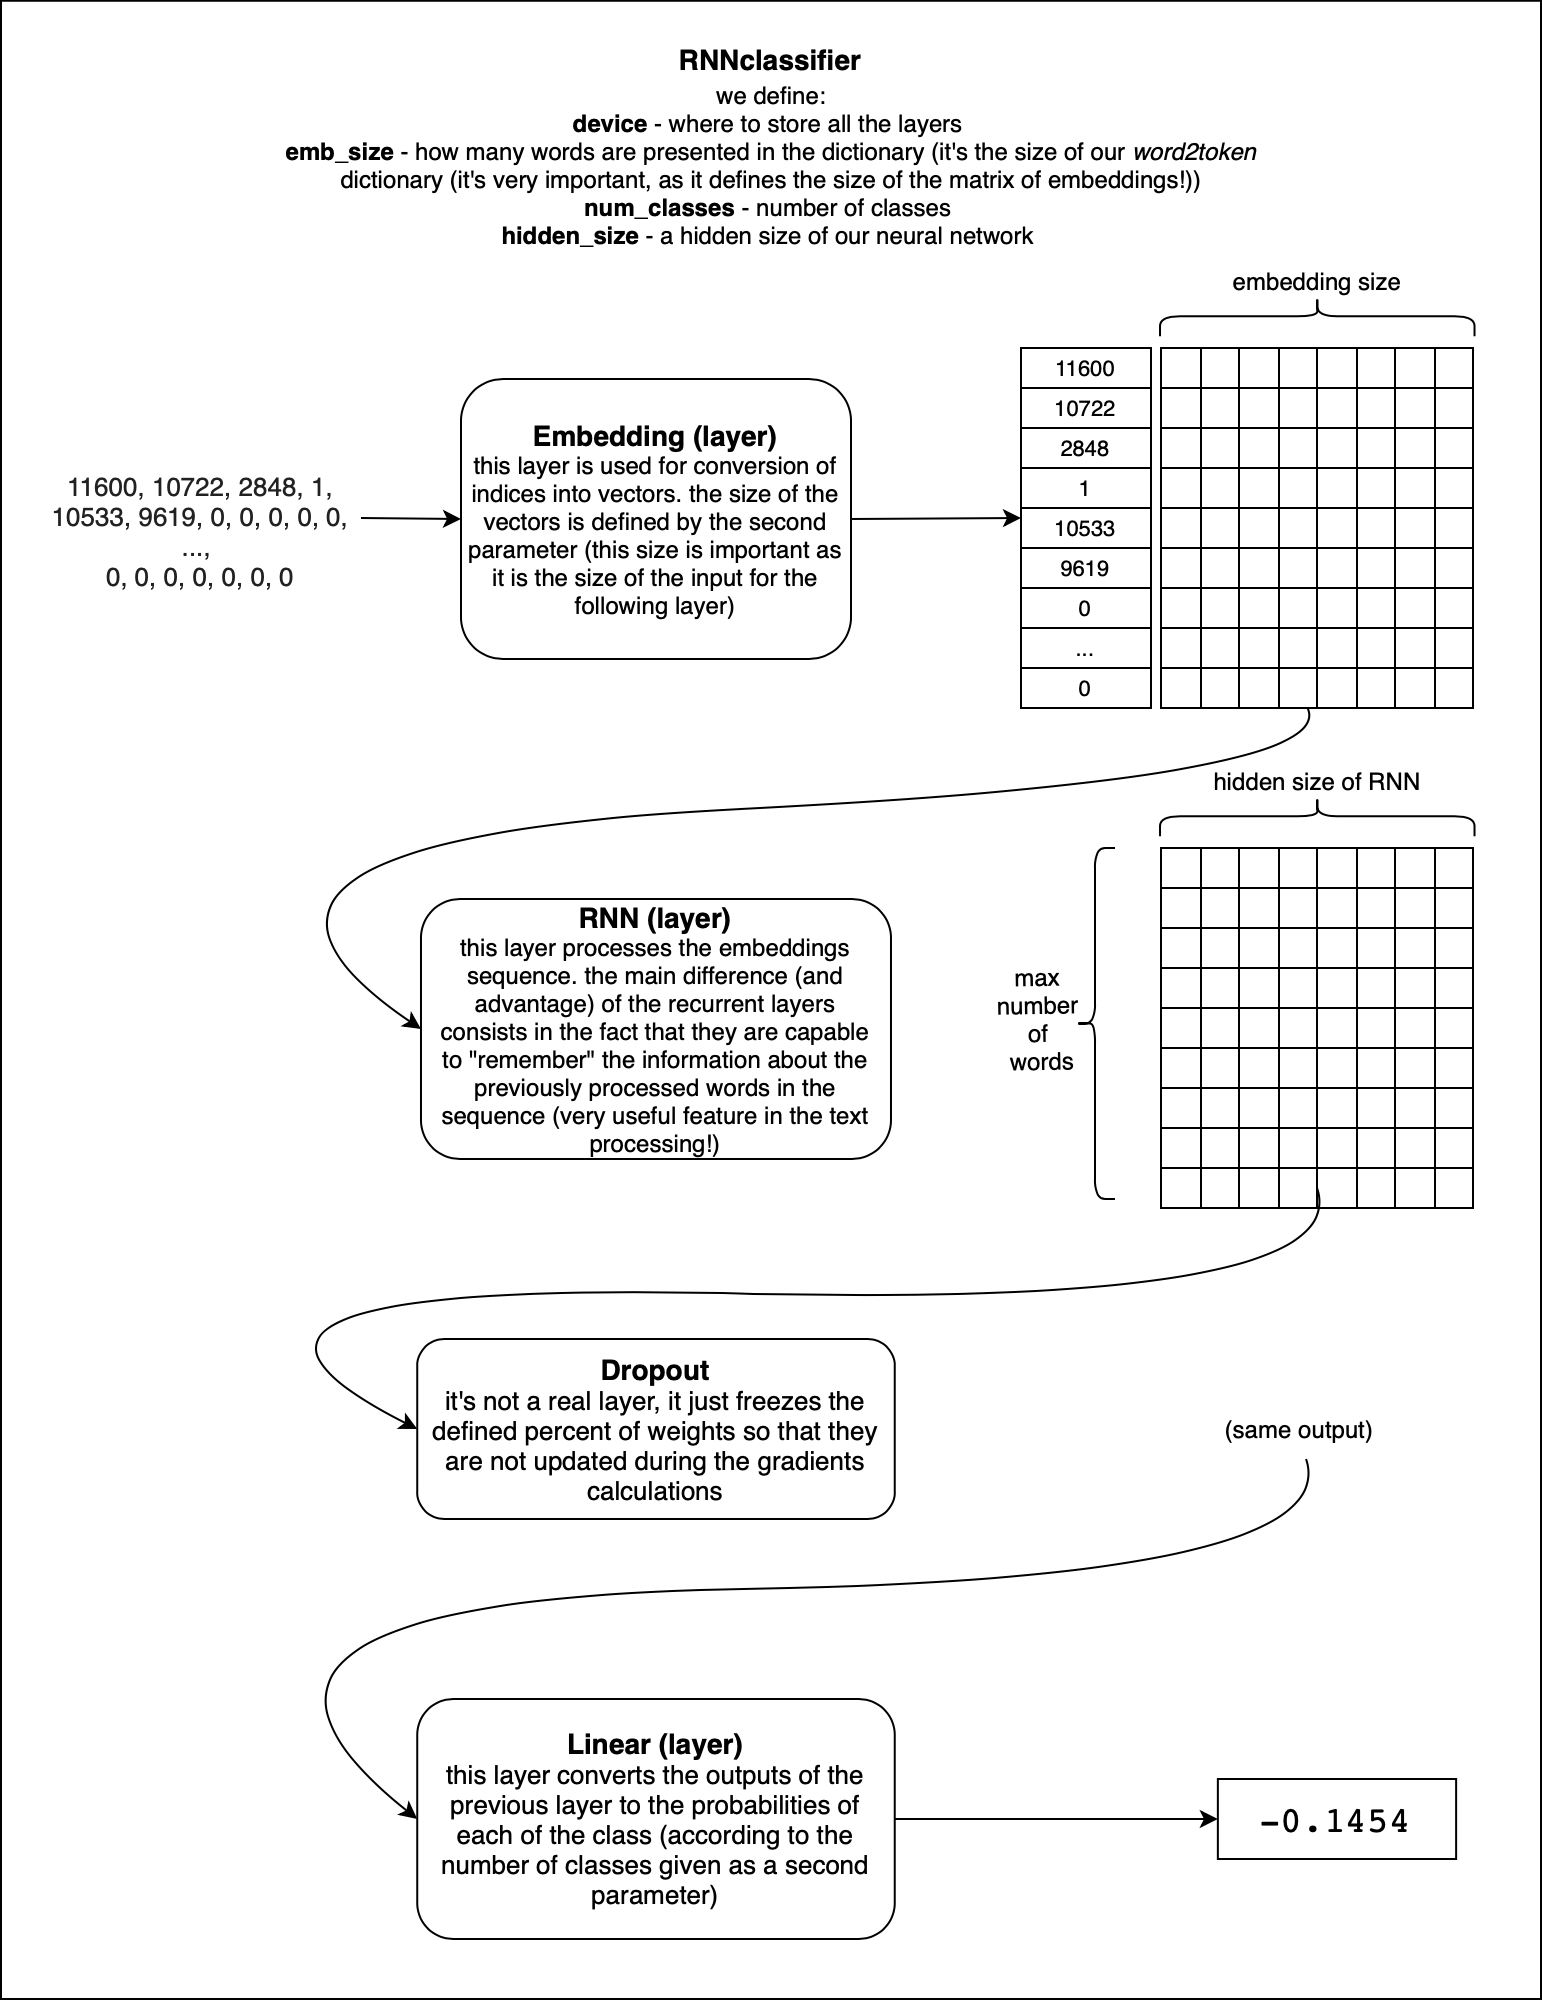

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, f1_score
from nltk.tokenize import TweetTokenizer, word_tokenize
from transformers import BertModel, BertTokenizerFast, RobertaTokenizerFast, RobertaModel, AlbertTokenizerFast, AlbertModel
from statistics import mean, mode, median
from collections import Counter
import os
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

collecting data

In [4]:
!git clone https://github.com/facebookresearch/SentEval.git

Cloning into 'SentEval'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 691 (delta 0), reused 0 (delta 0), pack-reused 689
Receiving objects: 100% (691/691), 33.25 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (434/434), done.


In [5]:
%%capture
os.chdir("SentEval/data/downstream")
!./get_transfer_data.bash
os.chdir("../../..")

In [6]:
train = pd.read_csv('/content/SentEval/data/downstream/SST/binary/sentiment-train', sep='\t', header=None)
test = pd.read_csv('/content/SentEval/data/downstream/SST/binary/sentiment-test', sep='\t', header=None)
dev = pd.read_csv('/content/SentEval/data/downstream/SST/binary/sentiment-dev', sep='\t', header=None)

processing the data

a little check of the tokenizers

In [ ]:
tokenize = TweetTokenizer()

In [ ]:
tokenize.tokenize("they aren't ")

['they', "aren't"]

In [ ]:
word_tokenize("they aren't ")

['they', 'are', "n't"]

splitting sentences into words

In [ ]:
train_ex = [tokenize.tokenize(text) for text in train[0]]
train_lab = train[1]

In [ ]:
dev_ex = [tokenize.tokenize(text) for text in dev[0][:100]]
dev_lab = dev[1][:100]

In [ ]:
test_ex = [tokenize.tokenize(text) for text in test[0]]
test_lab = test[1]

a little bit of stats

In [ ]:
c = Counter(train_lab)
print(f"Number of positive examples: {c[0]}\nNumber of negative examples: {c[1]}")

Number of positive examples: 29780
Number of negative examples: 37569


In [ ]:
lengths = [len(x) for x in train_ex]
print(f"median: {median(lengths)}\nmode: {mode(lengths)}\nmean: {round(mean(lengths))}\nmax: {max(lengths)}\nmin: {min(lengths)}")

median: 7
mode: 2
mean: 10
max: 55
min: 1


creating a dictionary of all the words in the train set (UNK is also important for further inference!)

In [ ]:
word2token = {'PAD':0, 'UNK':1}
all_words = set()
for text in train_ex:
  for word in text:
    all_words.add(word)
for word in all_words:
  word2token[word] = len(word2token)

creating a class for our neural network

In [ ]:
class RNNclassifier(nn.Module):
  def __init__(self, device, emb_size, num_classes=1, dropout=0.4, hidden_size=100):
    super(RNNclassifier, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.emb_size = emb_size
    self.dropout = dropout
    self.num_classes = num_classes
    self.embedding = nn.Embedding(self.emb_size, self.hidden_size).to(self.device)
    self.rnn = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True).to(self.device)
    self.dropout = nn.Dropout(self.dropout)
    self.linear = nn.Linear(self.hidden_size, self.num_classes).to(self.device)

  def forward(self, tokens, attention_ids, length):
    embs = self.embedding(tokens)
    rnn_out, hidden = self.rnn(embs)
    drop_out = self.dropout(rnn_out)
    output_zero_padding = drop_out.permute([2, 0, 1]) * attention_ids
    output_zero_padding = output_zero_padding.permute([1, 2, 0])
    out = torch.sum(output_zero_padding, 1).T/length
    out = out.T
    out = self.linear(out)
    return out

creating a dataset class for iterating through our data

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, texts, labels, maxlen, word2token, device):
    self.texts = texts
    self.labels = labels
    self.device = device
    self.maxlen = maxlen
    self.word2token = word2token
  
  def __getitem__(self, item):
    text = self.texts[item]
    label = self.labels[item]
    transformed_text = [self.word2token.get(word, 1) for word in text]
    transformed_text = torch.tensor(transformed_text+[self.word2token['PAD'] for _ in range(self.maxlen - len(transformed_text))], dtype=torch.long, device=self.device)
    attention_ids = torch.tensor([1 for _ in range(len(text))]+[0 for _ in range(self.maxlen - len(text))], dtype=torch.long, device=self.device)
    return transformed_text, len(text), attention_ids, label

  def __len__(self):
    return len(self.texts)

creating a training loop for our model

In [ ]:
def train_model(model, dataloader, dev_dataloader, epoches):
  optimizer = optim.RMSProp(model.parameters(), lr=0.01) # Adam, AdamW, Adadelta, Adagrad, SGD, RMSProp
  binary = nn.BCEWithLogitsLoss()
  best_f = 0
  for epoch in range(epoches):
    print(epoch+1, "epoch")
    t = tqdm(dataloader)
    i = 0
    for sentence, length, attention_ids, label in t:
      pred = model(sentence, attention_ids, length)
      loss = binary(pred.view(-1), label.type(torch.float32))
      if i % 10 == 0:
          torch.save(model, 'model.pt')
          predicted = []
          true = []
          with torch.no_grad():
              for sentence, length, attention_ids, label in dev_dataloader:
                pred = model(sentence, attention_ids, length)
                idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
                predicted.append(idx)
                true.append(label.item())
          f1 = f1_score(true, predicted, average='macro')
          if f1 > best_f:
            torch.save(model, f"{round(f1, 3)}model.pt")
            best_f = f1
            print("Saving with score", best_f)
      i += 1
      t.set_description(f"loss: {round(float(loss), 3)}, f-macro: {round(f1, 3)}")
      t.refresh()
      loss.backward()
      optimizer.step()
      model.zero_grad()

initializing instances of the train, test and dev datasets

In [ ]:
trainds = Dataset(train_ex, train_lab, 55, word2token, device)
devds = Dataset(dev_ex[:100], dev_lab[:100], 55, word2token, device)
testds = Dataset(test_ex, test_lab, 55, word2token, device)

initializing their dataloaders

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainds, batch_size=128)
dev_dataloader = torch.utils.data.DataLoader(devds, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(testds, batch_size=1)

initializing our model

In [ ]:
model = RNNclassifier(device, len(word2token), 1, 0.4, 100)

switching the model to the training mode

In [ ]:
model.train()

RNNclassifier(
  (embedding): Embedding(14704, 100)
  (rnn): RNN(100, 100, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

starting the training loop

In [ ]:
train_model(model, train_dataloader, dev_dataloader, epoches=3)

1 epoch


Saving with score 0.4212484497726333
Saving with score 0.4318181818181819
Saving with score 0.5087719298245614


switching to the evaluation mode (where gradients are not updated)

In [ ]:
model.eval()

In [ ]:
def evaluate(model, test_dataloader):
  predicted = []
  true = []
  with torch.no_grad():
    for sentence, length, attention_ids, label in test_dataloader:
      pred = model(sentence, attention_ids, length)
      idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
      predicted.append(idx)
      true.append(label.item())
  print(classification_report(true, predicted))

In [ ]:
evaluate(torch.load('0.86model.pt'), test_dataloader)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       912
           1       0.83      0.79      0.81       909

    accuracy                           0.82      1821
   macro avg       0.82      0.82      0.82      1821
weighted avg       0.82      0.82      0.82      1821



the same thing with the CNN

In [ ]:
class CNNclassifier(nn.Module):
  def __init__(self, device, maxlen, max_pool, emb_size, num_classes=2, hidden_size=100):
    super(CNNclassifier, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.maxlen = maxlen
    self.max_pool = max_pool
    self.emb_size = emb_size
    self.embedding = nn.Embedding(self.emb_size, self.hidden_size).to(self.device)
    self.cnn = nn.Conv1d(self.hidden_size, int(self.hidden_size/2), 3)
    self.maxpool = nn.MaxPool1d(int(self.maxlen-2))
    self.linear = nn.Linear(int((self.hidden_size/2)), num_classes).to(self.device)

  def forward(self, tokens, attention_ids, length):
    embs = self.embedding(tokens)
    embs = embs.permute(0,2,1)
    cnn_out = self.cnn(embs)
    max_out = self.maxpool(cnn_out)
    max_out = max_out.permute(0,2,1)
    out = self.linear(max_out)
    out = out.squeeze(1)
    return out

In [ ]:
cn = CNNclassifier(device, 55, 3, len(word2token), 1)
cn.train()

CNNclassifier(
  (embedding): Embedding(14704, 100)
  (cnn): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=53, stride=53, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
train_model(cn, train_dataloader, dev_dataloader, 3)

1 epoch


Saving with score 0.38694554633970424
Saving with score 0.5538956323270048
Saving with score 0.6161616161616162
Saving with score 0.7189883580891208
Saving with score 0.769792813532179
Saving with score 0.7785829307568438
Saving with score 0.8199279711884755
Saving with score 0.82998299829983

2 epoch



3 epoch


In [ ]:
cn.eval()

CNNclassifier(
  (embedding): Embedding(14704, 100)
  (cnn): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=53, stride=53, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
evaluate(torch.load('0.83model.pt'), test_dataloader)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       912
           1       0.80      0.79      0.79       909

    accuracy                           0.80      1821
   macro avg       0.80      0.80      0.80      1821
weighted avg       0.80      0.80      0.80      1821



the same thing with BERT embeddings

In [7]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [8]:
class bertDataset(torch.utils.data.Dataset):
  def __init__(self, texts, labels, tokenizer, device):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.device = device
  
  def __getitem__(self, item):
    text = self.texts[item]
    label = self.labels[item]
    tokens = self.tokenizer(text, padding='max_length', max_length=55, truncation=True, return_tensors='pt', is_split_into_words=False).to(self.device)
    tokens['input_ids'] = torch.squeeze(tokens['input_ids'], 0)[:512]
    tokens['attention_mask'] = torch.squeeze(tokens['attention_mask'], 0)[:512]
    tokens['token_type_ids'] = torch.squeeze(tokens['token_type_ids'], 0)[:512]
    length = sum(tokens['attention_mask']).item()
    label = torch.tensor(label, dtype=torch.float32, device=self.device)
    return tokens, length, label

  def __len__(self):
    return len(self.texts)

In [9]:
bert_train = bertDataset(train[0], train[1], tokenizer, device)
bert_dev = bertDataset(dev[0], dev[1], tokenizer, device)
bert_test = bertDataset(test[0], test[1], tokenizer, device)
bert_tdataloader = torch.utils.data.DataLoader(bert_train, batch_size=64)
bert_ddataloader = torch.utils.data.DataLoader(bert_dev, batch_size=1)
bert_ttdataloader = torch.utils.data.DataLoader(bert_test, batch_size=1)

In [10]:
class BERT_GRU(nn.Module):
  def __init__(self, device, num_classes=1, hidden_size=100, model_name="bert-base-multilingual-cased"):
    super(BERT_GRU, self).__init__()
    self.device = device
    self.bert = BertModel.from_pretrained(model_name).to(self.device)
    self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True).to(self.device)
    self.dropout = nn.Dropout(0.4).to(self.device)
    self.linear = nn.Linear(hidden_size, num_classes).to(self.device)

  def forward(self, tokens, length):
    with torch.no_grad():
        output = self.bert(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], token_type_ids=tokens['token_type_ids'], return_dict=True)
    lstm_out, hidden = self.gru(output['last_hidden_state']) #its size is equal to batch_size, sequence_size, embedding_size (in case of this notebook, it's 32, 55, 768)
    lstm_out = self.dropout(lstm_out)
    output_zero_padding = lstm_out.permute([2, 0, 1]) * tokens['attention_mask']
    output_zero_padding = output_zero_padding.permute([1, 2, 0]).to(self.device)
    linear = torch.sum(output_zero_padding, 1).to(self.device)
    length = length.to(self.device)
    linear = linear.T/length
    linear = linear.T
    out = self.linear(linear)
    return out

In [29]:
def bert_train_model(model, dataloader, dev_dataloader, epoches):
  optimizer = optim.Adam(model.parameters(), lr=1e-5) #lr 1e-5 and adam for roberta and albert
  binary = nn.BCEWithLogitsLoss()
  best_f = 0
  for epoch in range(epoches):
    print(epoch+1, "epoch")
    t = tqdm(dataloader)
    i = 0
    for sentence, length, label in t:
      pred = model(sentence, length)
      loss = binary(pred.view(-1), label)
      if i % 300 == 0:
          torch.save(model, 'model.pt')
          predicted = []
          true = []
          with torch.no_grad():
              for sentence, length, label in dev_dataloader:
                pred = model(sentence, length)
                idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
                predicted.append(idx)
                true.append(label.item())
          f1 = f1_score(true, predicted, average='macro')
          if f1 > best_f:
            torch.save(model, f"{round(f1, 3)}model.pt")
            best_f = f1
            print("Saving with score", best_f)
      i += 1
      t.set_description(f"loss: {round(float(loss), 3)}, f-macro: {round(f1, 3)}")
      t.refresh()
      loss.backward()
      optimizer.step()
      model.zero_grad()

In [30]:
def bert_evaluate(model, test_dataloader):
  predicted = []
  true = []
  with torch.no_grad():
    for sentence, length, label in test_dataloader:
      pred = model(sentence, length)
      idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
      predicted.append(idx)
      true.append(label.item())
  print(classification_report(true, predicted))

In [14]:
m = BERT_GRU(device, 1, 100)
m.train()

BERT_GRU(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
bert_train_model(m, bert_tdataloader, bert_ddataloader, 10)

1 epoch


Saving with score 0.44442658707381466
Saving with score 0.7351462136578769
Saving with score 0.7481576716323355

2 epoch


Saving with score 0.7590716522379812

3 epoch


Saving with score 0.7735318739412156
Saving with score 0.7739752612749877

4 epoch


Saving with score 0.7769303669536287

5 epoch



6 epoch



7 epoch


Saving with score 0.7821055068072302
Saving with score 0.7866691920387645

8 epoch



9 epoch


Saving with score 0.7873268866960654
Saving with score 0.7878214343492003

10 epoch


Saving with score 0.7943545252728865



In [22]:
class BERTclassifier(nn.Module):
  def __init__(self, device, num_classes=1, model_name="bert-base-multilingual-cased"):
    super(BERTclassifier, self).__init__()
    self.device = device
    self.bert = BertModel.from_pretrained(model_name).to(self.device)
    self.linear = nn.Linear(768, num_classes).to(self.device)

  def forward(self, tokens, length):
    output = self.bert(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], token_type_ids=tokens['token_type_ids'], return_dict=True)
    output = output['last_hidden_state'][:,0] #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
    out = self.linear(output)
    return out

In [25]:
b = BERTclassifier(device, 1)
b.train()

BERTclassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [26]:
bert_train_model(b, bert_tdataloader, bert_ddataloader, 3)

1 epoch


Saving with score 0.45289201578588034
Saving with score 0.8260384752075233
Saving with score 0.8635319306191748
Saving with score 0.8680274526060894

2 epoch


Saving with score 0.8784243782586507
Saving with score 0.8818457717398598
Saving with score 0.8830053667262969

3 epoch


Saving with score 0.8933249146622995



In [28]:
b.eval()

BERTclassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [31]:
bert_evaluate(b, bert_ttdataloader)

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       912
         1.0       0.87      0.92      0.89       909

    accuracy                           0.89      1821
   macro avg       0.89      0.89      0.89      1821
weighted avg       0.89      0.89      0.89      1821



same thing with roberta

In [7]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [43]:
class robertaDataset(torch.utils.data.Dataset):
  def __init__(self, texts, labels, tokenizer, device, al=False):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.device = device
    self.al = al
  
  def __getitem__(self, item):
    text = self.texts[item]
    label = self.labels[item]
    tokens = self.tokenizer(text, padding='max_length', max_length=55, truncation=True, return_tensors='pt').to(self.device)
    tokens['input_ids'] = torch.squeeze(tokens['input_ids'], 0)
    tokens['attention_mask'] = torch.squeeze(tokens['attention_mask'], 0)
    if self.al:
      tokens['token_type_ids'] = torch.squeeze(tokens['token_type_ids'], 0)[:512]
    length = sum(tokens['attention_mask']).item()
    label = torch.tensor(label, dtype=torch.float32, device=self.device)
    return tokens, length, label

  def __len__(self):
    return len(self.texts)

In [15]:
class roBERTaclassifier(nn.Module):
  def __init__(self, device, num_classes=1, model_name='roberta-base'):
    super(roBERTaclassifier, self).__init__()
    self.device = device
    self.roberta = RobertaModel.from_pretrained(model_name).to(self.device)
    self.linear = nn.Linear(768, num_classes).to(self.device)

  def forward(self, tokens, length):
    output = self.roberta(**tokens)
    output = output.last_hidden_state[:,0] #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
    out = self.linear(output)
    return out

In [18]:
rob = roBERTaclassifier(device)
rob.train()

roBERTaclassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [9]:
roberta_train = robertaDataset(train[0], train[1], tokenizer, device)
roberta_dev = robertaDataset(dev[0], dev[1], tokenizer, device)
roberta_test = robertaDataset(test[0], test[1], tokenizer, device)
roberta_tdataloader = torch.utils.data.DataLoader(roberta_train, batch_size=16)
roberta_ddataloader = torch.utils.data.DataLoader(roberta_dev, batch_size=1)
roberta_ttdataloader = torch.utils.data.DataLoader(roberta_test, batch_size=1)

In [ ]:
bert_train_model(rob, roberta_tdataloader, roberta_ddataloader, 1)

In [24]:
rob.eval()

roBERTaclassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [25]:
bert_evaluate(rob, roberta_ttdataloader)

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       912
         1.0       0.93      0.98      0.95       909

    accuracy                           0.95      1821
   macro avg       0.96      0.95      0.95      1821
weighted avg       0.96      0.95      0.95      1821



the same thing with albert

In [11]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [45]:
class ALBERTclassifier(nn.Module):
  def __init__(self, device, num_classes=1, model_name='albert-base-v2'):
    super(ALBERTclassifier, self).__init__()
    self.device = device
    self.albert = AlbertModel.from_pretrained(model_name).to(self.device)
    self.linear = nn.Linear(768, num_classes).to(self.device)

  def forward(self, tokens, length):
    output = self.albert(**tokens)
    output = output.last_hidden_state[:,0] #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
    out = self.linear(output)
    return out

In [44]:
albert_train = robertaDataset(train[0], train[1], albert_tokenizer, device, True)
albert_dev = robertaDataset(dev[0], dev[1], albert_tokenizer, device, True)
albert_test = robertaDataset(test[0], test[1], albert_tokenizer, device, True)
albert_tdataloader = torch.utils.data.DataLoader(albert_train, batch_size=16)
albert_ddataloader = torch.utils.data.DataLoader(albert_dev, batch_size=1)
albert_ttdataloader = torch.utils.data.DataLoader(albert_test, batch_size=1)

In [47]:
albert = ALBERTclassifier(device)
albert.train()

ALBERTclassifier(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
   

In [48]:
bert_train_model(albert, albert_tdataloader, albert_ddataloader, 1)

1 epoch


Saving with score 0.37593409922782767
Saving with score 0.7989958521957721
Saving with score 0.9058518678471172
Saving with score 0.9079037002223197
Saving with score 0.9151304713804714

2 epoch


Saving with score 0.9242098609355246

3 epoch



4 epoch



5 epoch



6 epoch



7 epoch



8 epoch



9 epoch



10 epoch


In [49]:
albert.eval()

ALBERTclassifier(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
   

In [50]:
bert_evaluate(albert, albert_ttdataloader)

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       912
         1.0       0.90      0.93      0.91       909

    accuracy                           0.91      1821
   macro avg       0.91      0.91      0.91      1821
weighted avg       0.91      0.91      0.91      1821

